In [ ]:
from collections import Counter
import math
import time
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


In [ ]:
CACHED_RESULTS = True

# 1. Loading the Data

In [ ]:
df_raw = pd.read_csv('data/HiRID.csv')
df_raw.drop(columns = ['Unnamed: 0'], inplace = True)
df_raw.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


# 2. Evaluating Missingness

In [ ]:
def plot_missingness(df, plot_title, save_path=None):
    """
    input:
        df: pd.DataFrame
        plot_title: str
        save_path: str, e.g. 'plots/missingness.png'
    """
    if os.path.exists(save_path) and CACHED_RESULTS:
        plt.imshow(plt.imread(save_path))
        plt.axis('off')
        # make the plot a bit larger
        plt.gcf().set_size_inches(10, 5)
        # remove the extra white space on the edges
        plt.gca().set_position([0, 0, 1, 1])
        plt.show()
        return

    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title(plot_title)
    plt.xlabel('Feature')
    plt.ylabel('Sample')
    if save_path:
        if not os.path.exists('plots'):
            os.makedirs('plots')
        plt.savefig(save_path)
    plt.show()

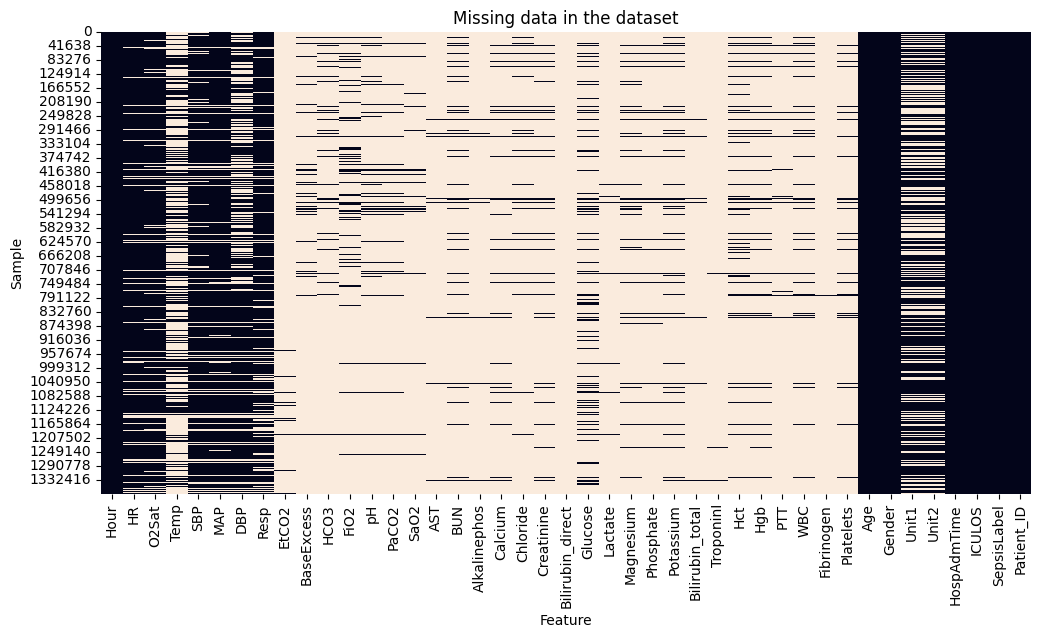

In [ ]:
plot_missingness(df_raw, plot_title='Missing data in the dataset',
                save_path='plots/missingness_raw.png')

# 3. Data Imputation

In [ ]:
missing_percentages = (df_raw.isnull().sum() / len(df_raw)) * 100

missing_percentages = missing_percentages.sort_values(ascending=False)

for column, percentage in missing_percentages.items():
    print(f"{column}: {percentage:.2f}% missing")

Bilirubin_direct: 99.82% missing
Fibrinogen: 99.33% missing
TroponinI: 99.16% missing
Bilirubin_total: 98.54% missing
Alkalinephos: 98.41% missing
AST: 98.39% missing
Lactate: 97.24% missing
EtCO2: 96.82% missing
PTT: 96.81% missing
SaO2: 96.35% missing
Phosphate: 95.85% missing
HCO3: 95.29% missing
Chloride: 94.96% missing
Calcium: 94.24% missing
PaCO2: 94.02% missing
Platelets: 93.98% missing
BaseExcess: 93.91% missing
Creatinine: 93.83% missing
Magnesium: 93.49% missing
WBC: 93.44% missing
BUN: 92.96% missing
pH: 92.47% missing
Hgb: 92.42% missing
FiO2: 90.89% missing
Hct: 90.75% missing
Potassium: 90.49% missing
Glucose: 83.55% missing
Temp: 66.18% missing
Unit1: 40.60% missing
Unit2: 40.60% missing
DBP: 33.61% missing
SBP: 14.67% missing
Resp: 14.62% missing
O2Sat: 12.93% missing
MAP: 12.16% missing
HR: 9.60% missing
HospAdmTime: 0.00% missing
SepsisLabel: 0.00% missing
ICULOS: 0.00% missing
Hour: 0.00% missing
Gender: 0.00% missing
Age: 0.00% missing
Patient_ID: 0.00% missing


- Forward-filling and Back-filling within patient

In [ ]:
df_fill = df_raw.set_index('Patient_ID') #allows us to preserve the groupby column
df_fill = df_fill.groupby('Patient_ID').transform(lambda x: x.ffill().bfill(limit = 1))
df_fill.reset_index(drop = False, inplace = True)


- For each remaining missing value in a given row, fill it by randomly selecting a value from the same column across all rows within the same SepsisLabel group.

In [13]:
# jcode
def rand_fill(col):
    non_missing_vals = col.dropna().values
    # for val x in col, is val is NaN, randomly impute with val from
    # col of existing vals
    if len(non_missing_vals) == 0:
      return col

    col = col.apply(lambda x: np.random.choice(non_missing_vals) if pd.isna(x) else x)
    return col



df_imp = df_fill.set_index('SepsisLabel', inplace = False)
df_imp = df_imp.groupby('SepsisLabel').transform(lambda x: rand_fill(x))
df_imp.reset_index(drop = False, inplace = True)
df_imp.head(500)




# df_fill.set_index('SepsisLabel', inplace = True) #allows us to preserve the groupby column
# df_fill = df_fill.groupby('SepsisLabel').transform(lambda x: x.fillna('median'))

,SepsisLabel,Patient_ID,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,0,17072,0,65.0,100.0,37.33,126.5,72.0,77.5,16.5,...,34.8,12.8,187.0,240.0,68.54,0,0.0,1.0,-0.02,1
1,0,17072,1,65.0,100.0,37.10,175.0,72.0,59.0,16.5,...,27.0,251.0,457.0,137.0,68.54,0,0.0,0.0,-0.02,2
2,0,17072,2,78.0,100.0,36.50,172.0,42.5,67.0,16.5,...,62.7,6.8,225.0,391.0,68.54,0,1.0,1.0,-0.02,3
3,0,17072,3,73.0,100.0,36.70,129.0,42.5,69.0,17.0,...,30.6,11.3,206.0,330.0,68.54,0,0.0,0.0,-0.02,4
4,0,17072,4,70.0,100.0,39.00,129.0,74.0,69.0,14.0,...,30.6,11.3,401.0,330.0,68.54,0,1.0,1.0,-0.02,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,1380,14,85.0,95.0,37.80,95.0,66.0,49.0,18.0,...,24.7,18.3,236.0,166.0,60.42,0,0.0,1.0,-2.85,19
496,0,1380,15,76.0,98.0,37.60,101.0,75.0,60.0,15.0,...,24.7,18.3,340.0,166.0,60.42,0,0.0,1.0,-2.85,20
497,0,1380,16,83.0,98.0,37.60,106.0,93.0,87.0,17.0,...,24.7,18.3,674.0,166.0,60.42,0,0.0,1.0,-2.85,21
498,0,1380,17,77.0,98.0,37.70,108.0,70.5,58.0,20.0,...,24.7,18.3,392.0,166.0,60.42,0,0.0,1.0,-2.85,22


In [14]:
# compare missing percentages
missing_comparison = pd.DataFrame({
    'Original Missing (%)': (df_raw.isnull().sum() / len(df_raw)) * 100,
    'Cleaned Missing (%)': (df_imp.isnull().sum() / len(df_imp)) * 100
})

print(missing_comparison)
df_imp.head(800)



                  Original Missing (%)  Cleaned Missing (%)
AST                          98.390355                  0.0
Age                           0.000000                  0.0
Alkalinephos                 98.409205                  0.0
BUN                          92.962090                  0.0
BaseExcess                   93.907120                  0.0
Bilirubin_direct             99.816088                  0.0
Bilirubin_total              98.541080                  0.0
Calcium                      94.244885                  0.0
Chloride                     94.958625                  0.0
Creatinine                   93.832522                  0.0
DBP                          33.608873                  0.0
EtCO2                        96.824451                  0.0
FiO2                         90.892339                  0.0
Fibrinogen                   99.330801                  0.0
Gender                        0.000000                  0.0
Glucose                      83.546720  

,SepsisLabel,Patient_ID,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,0,17072,0,65.0,100.0,37.33,126.5,72.0,77.5,16.5,...,34.8,12.8,187.0,240.0,68.54,0,0.0,1.0,-0.02,1
1,0,17072,1,65.0,100.0,37.10,175.0,72.0,59.0,16.5,...,27.0,251.0,457.0,137.0,68.54,0,0.0,0.0,-0.02,2
2,0,17072,2,78.0,100.0,36.50,172.0,42.5,67.0,16.5,...,62.7,6.8,225.0,391.0,68.54,0,1.0,1.0,-0.02,3
3,0,17072,3,73.0,100.0,36.70,129.0,42.5,69.0,17.0,...,30.6,11.3,206.0,330.0,68.54,0,0.0,0.0,-0.02,4
4,0,17072,4,70.0,100.0,39.00,129.0,74.0,69.0,14.0,...,30.6,11.3,401.0,330.0,68.54,0,1.0,1.0,-0.02,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,8253,22,101.0,99.0,37.72,101.0,71.5,58.0,14.0,...,44.0,10.0,160.0,217.0,39.76,1,1.0,1.0,-0.03,23
796,0,8253,23,96.0,99.0,37.17,97.0,72.0,60.0,12.0,...,34.7,10.0,341.0,217.0,39.76,1,0.0,1.0,-0.03,24
797,0,8253,24,95.0,99.0,37.17,99.0,72.0,61.0,15.0,...,25.0,10.0,878.0,217.0,39.76,1,0.0,1.0,-0.03,25
798,0,8253,25,99.0,100.0,37.17,124.0,87.0,69.0,14.0,...,32.9,10.0,180.0,217.0,39.76,1,0.0,1.0,-0.03,26


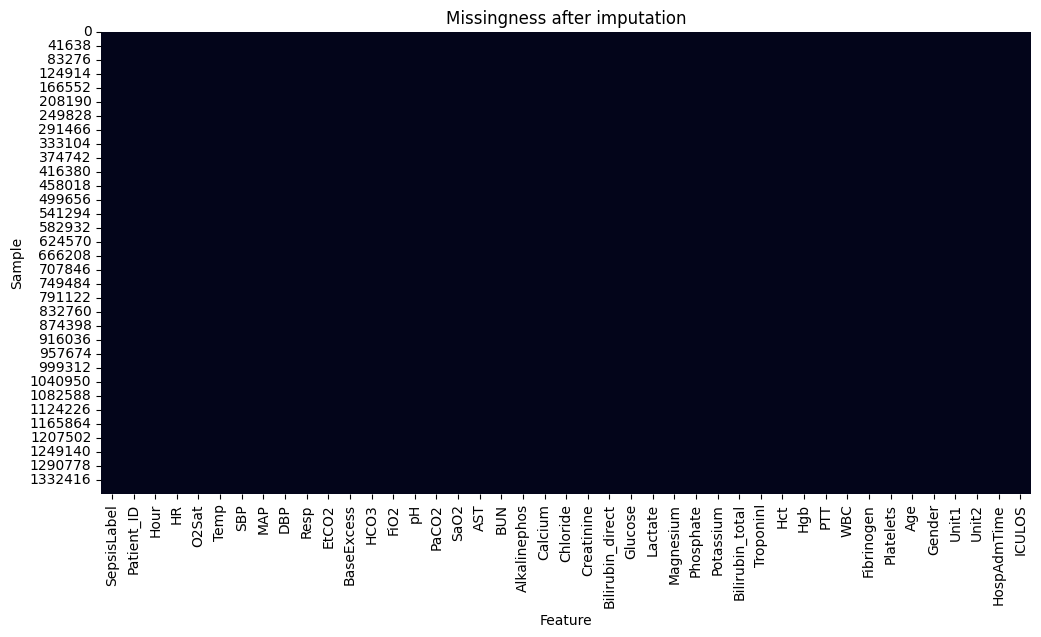

In [15]:
plot_missingness(df_imp, plot_title='Missingness after imputation',
                save_path='plots/missingness_imputed.png')

### 4. Scaling

In [ ]:
# columns to exclude from scaling
exclude_cols = ["SepsisLabel", "Hour", "Unit1", "Unit2", "Gender", "Patient id"]

cols_to_scale = [col for col in df_imp.columns if col not in exclude_cols]

# Create a copy of the DataFrame
df_scale = df_imp.copy()

# Scale each column individually
for col in cols_to_scale:
    scaler = StandardScaler()
    df_scale[col] = scaler.fit_transform(df_imp[[col]])

# Display the first 400 rows
df_scale.head(400)

### 5. Balancing

In [ ]:
# Count the number of sepsis vs non-sepsis patients in df_scale
sepsis_counts = df_scale['SepsisLabel'].value_counts()

# Display the count of sepsis vs non-sepsis patients
print(sepsis_counts)


In [18]:
# Separate the data into sepsis and non-sepsis groups
sepsis_patients = df_scale[df_scale['SepsisLabel'] == 1]
non_sepsis_patients = df_scale[df_scale['SepsisLabel'] == 0]

# Determine the number of sepsis patients
num_sepsis = len(sepsis_patients)

# Randomly sample the non-sepsis patients to match the number of sepsis patients
non_sepsis_sample = non_sepsis_patients.sample(n=num_sepsis, random_state=42)

# Concatenate the balanced sepsis and non-sepsis samples
df_bal = pd.concat([sepsis_patients, non_sepsis_sample]).reset_index(drop=True)

# Display the count of each class in the balanced dataset
print(df_bal['SepsisLabel'].value_counts())

SepsisLabel
1    25395
0    25395
Name: count, dtype: int64


# Summary of The Data

In [19]:
df_bal.head()

,SepsisLabel,Patient_ID,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,1,-0.835425,50,0.146728,0.909837,-0.826575,-0.793572,-1.053493,0.228474,0.059037,...,-0.455576,-0.260975,1.995276,-0.535374,-0.176078,1,1.0,0.0,0.339391,0.907981
1,1,-0.835425,51,0.492860,0.909837,1.784143,-1.270992,-0.623680,-0.552164,-0.134031,...,-0.455576,-0.260975,1.216945,-0.535374,-0.176078,1,1.0,0.0,0.339391,0.942861
2,1,-0.835425,52,0.608237,0.909837,0.085105,-0.576562,-0.132467,1.860717,-1.099371,...,-0.455576,-0.260975,1.723176,-0.535374,-0.176078,1,1.0,1.0,0.339391,0.977742
3,1,-0.835425,53,0.550549,0.909837,1.466437,-1.227591,-0.500877,-0.410230,0.252105,...,-0.455576,-0.260975,-0.023323,-0.535374,-0.176078,1,0.0,0.0,0.339391,1.012622
4,1,-0.835425,54,0.550549,0.909837,1.245424,-1.227591,-0.562279,-0.410230,0.638241,...,-0.455576,-0.260975,-0.339717,-0.535374,-0.176078,1,0.0,0.0,0.339391,1.047503


# Deeper Understanding of the Data

We will visualize how each of the columns below relates to the response variable 'SepsisLabel'.

In [20]:
cols = df_bal.drop('SepsisLabel', axis=1).columns
cols

Index(['Patient_ID', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS'],
      dtype='object')

First, we observe the distribution of each variable, grouped by our outcome of interest.

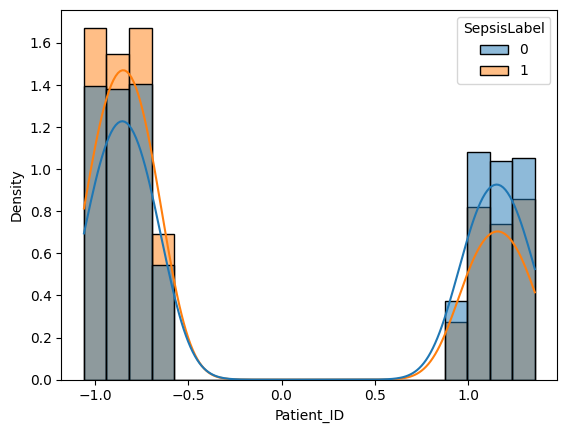

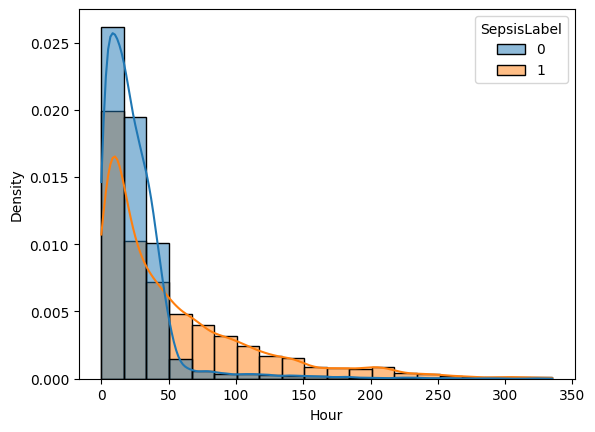

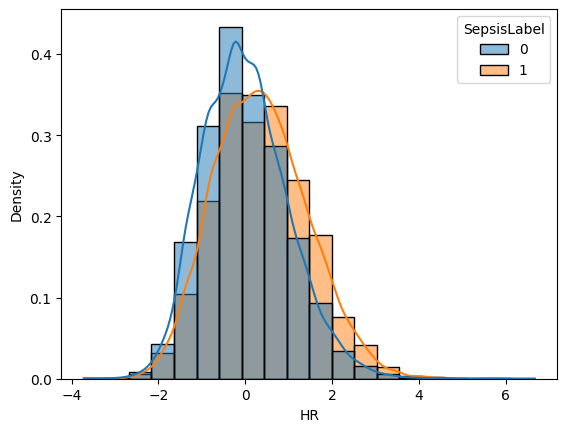

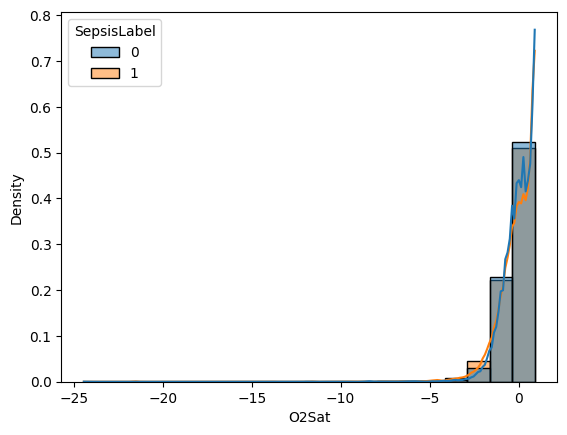

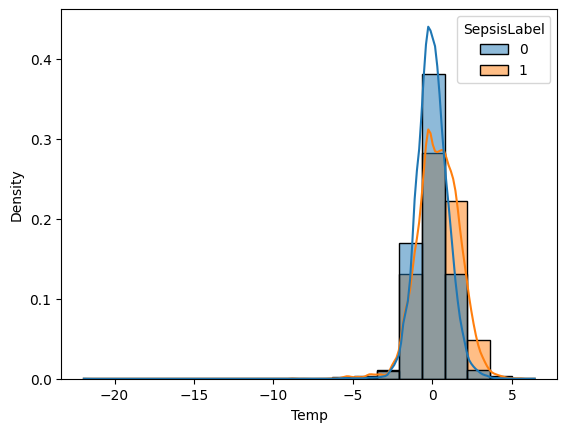

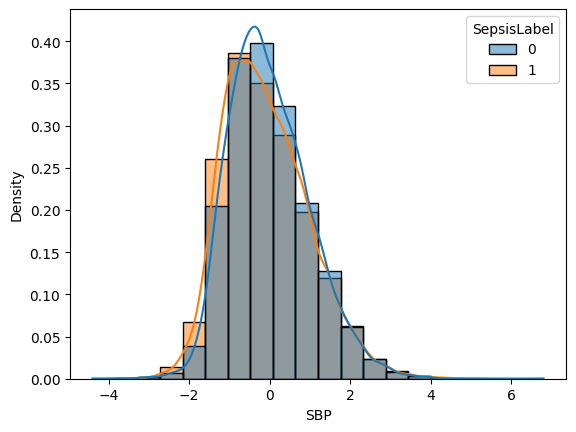

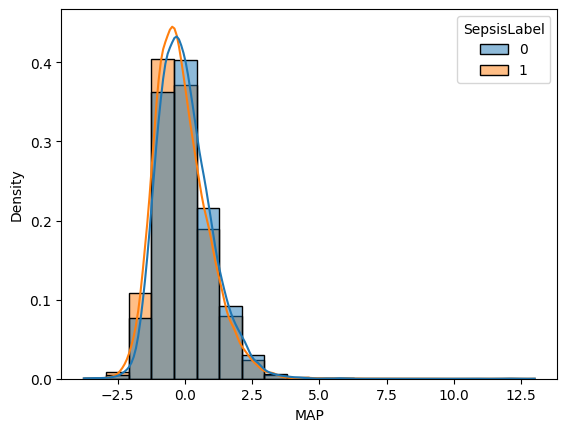

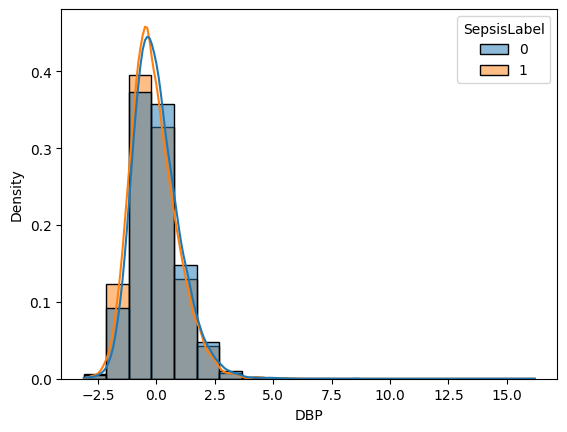

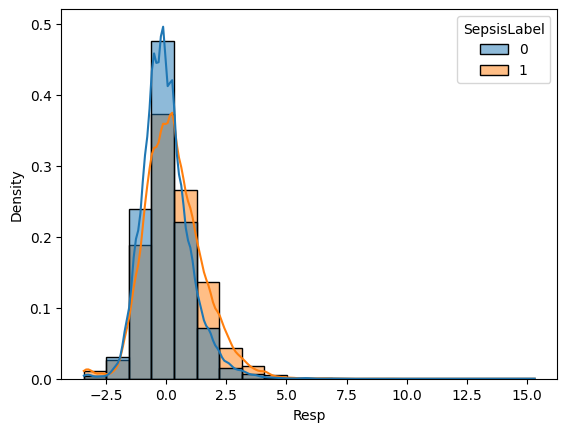

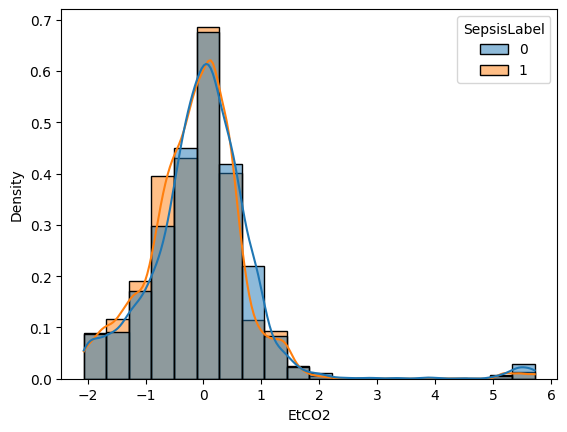

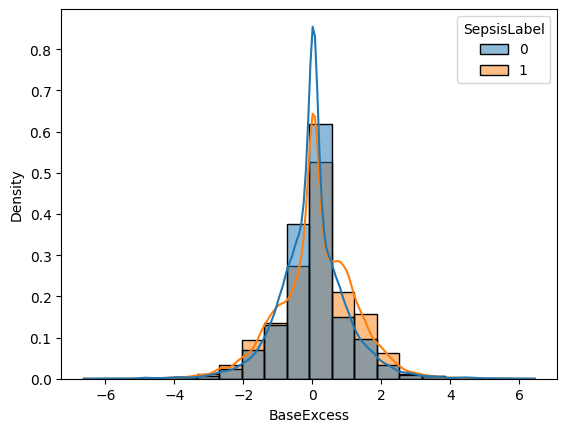

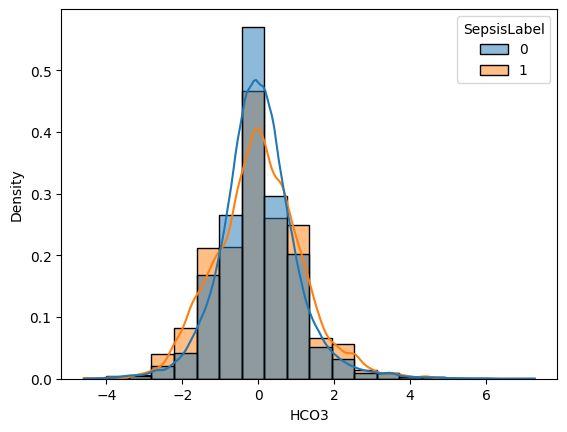

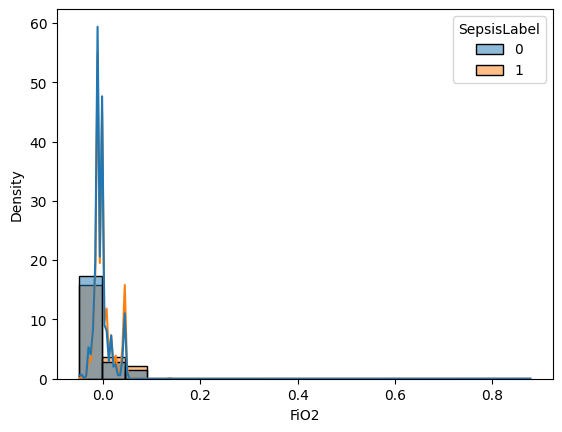

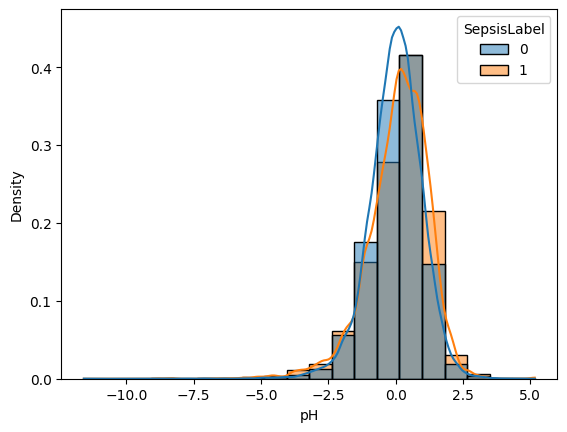

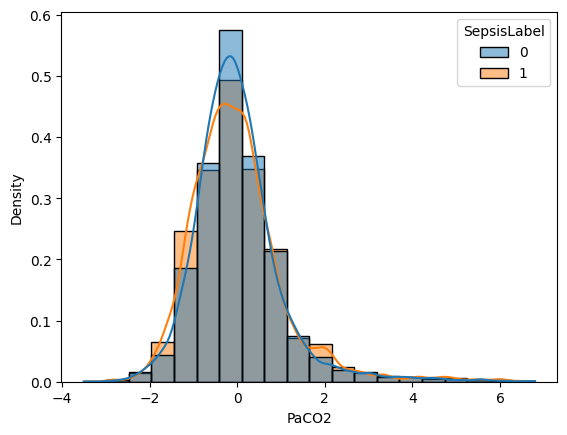

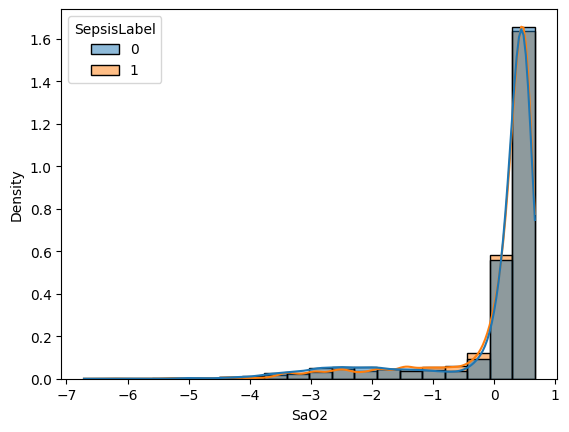

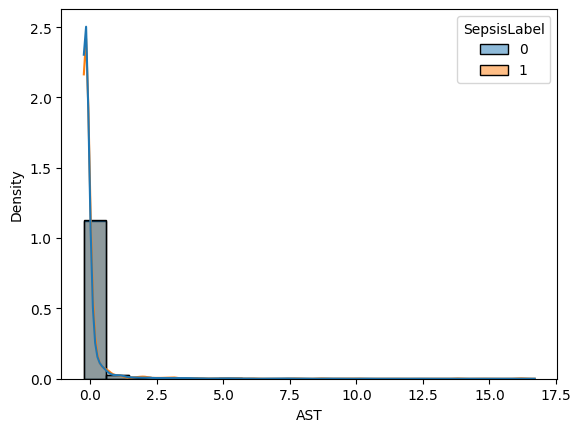

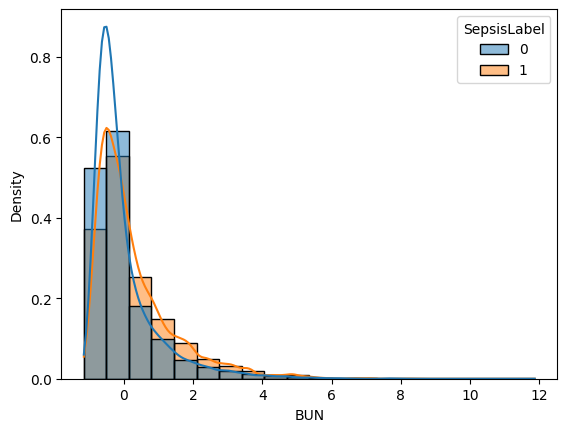

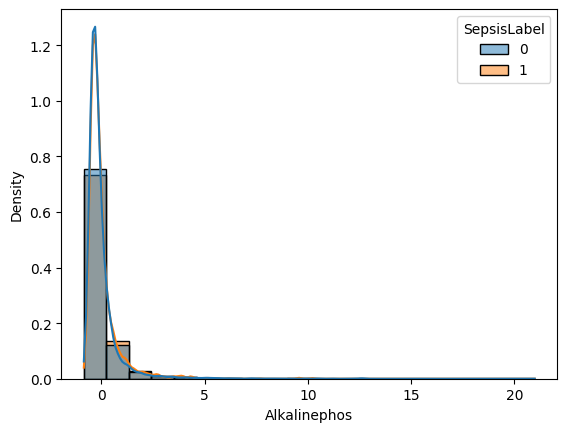

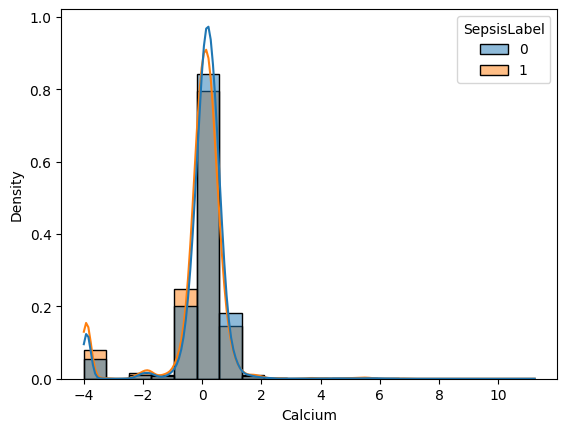

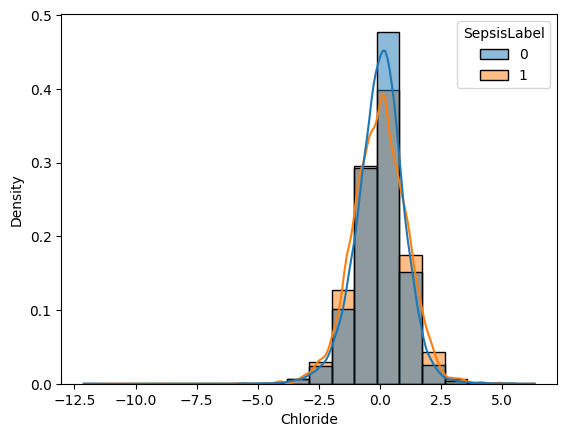

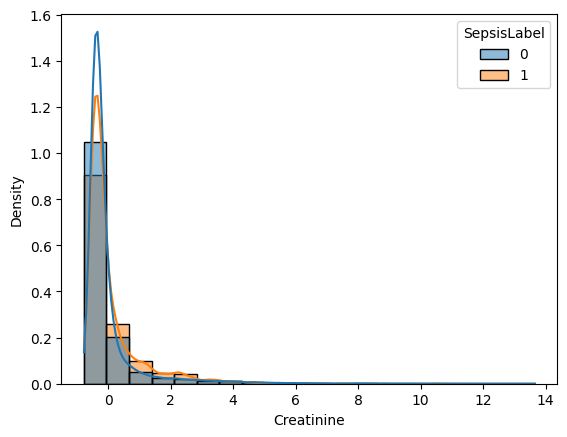

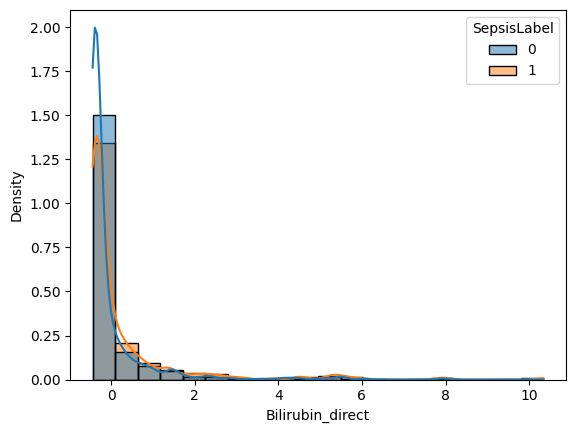

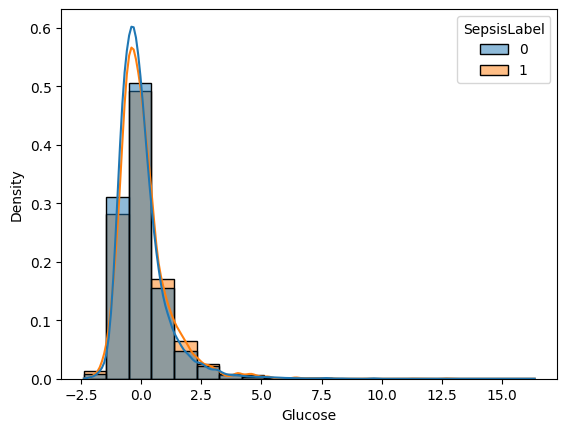

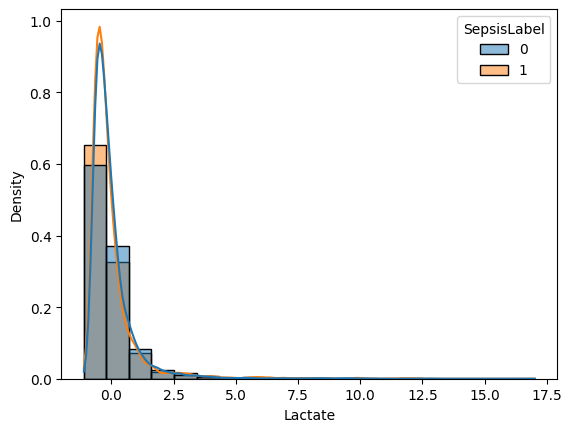

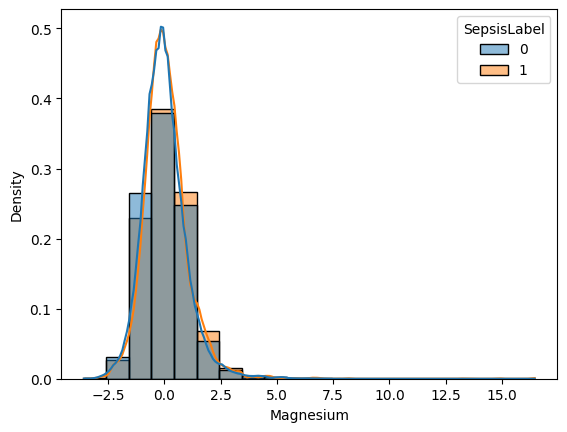

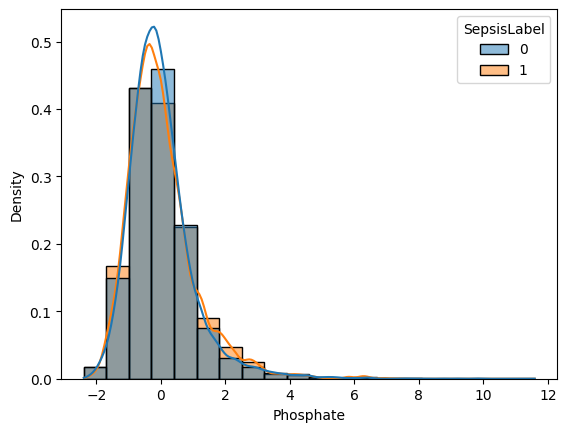

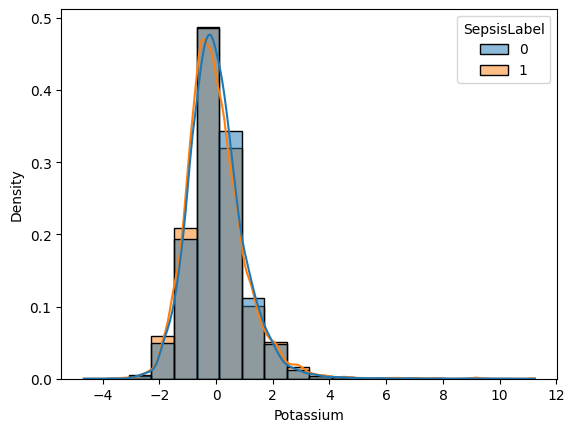

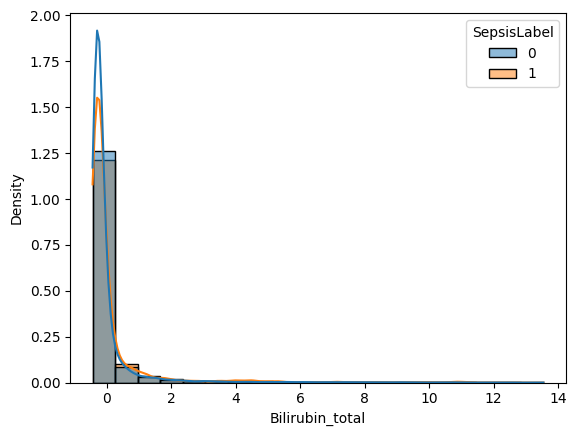

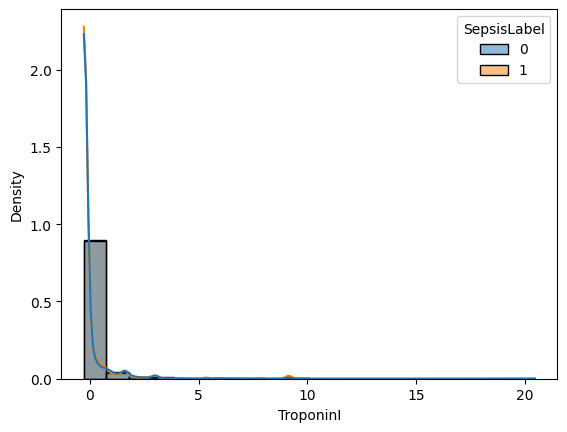

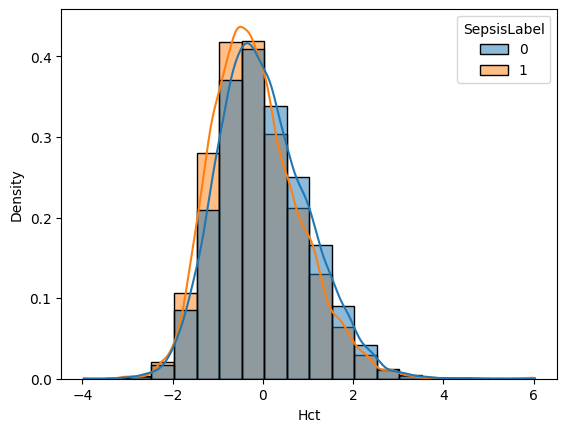

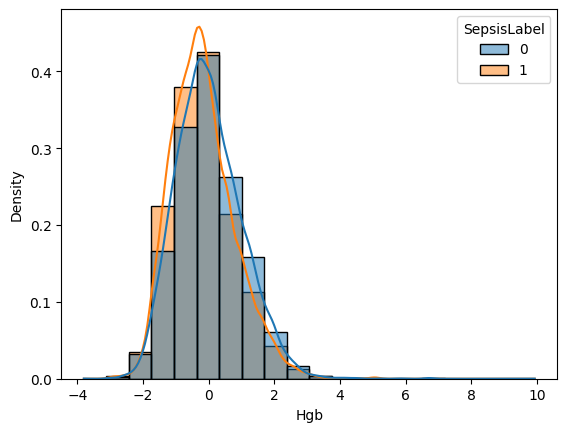

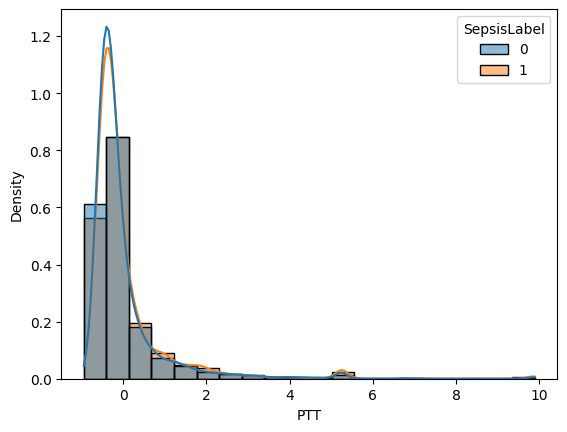

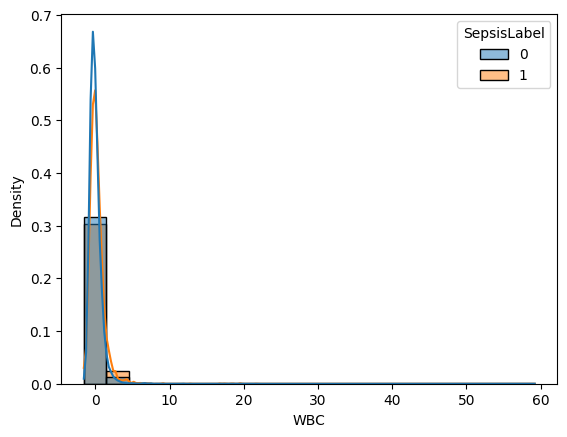

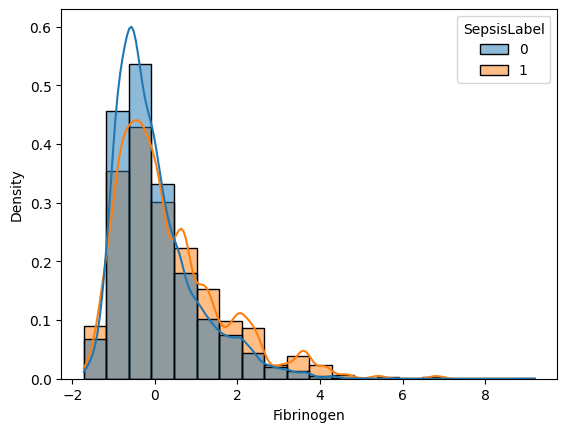

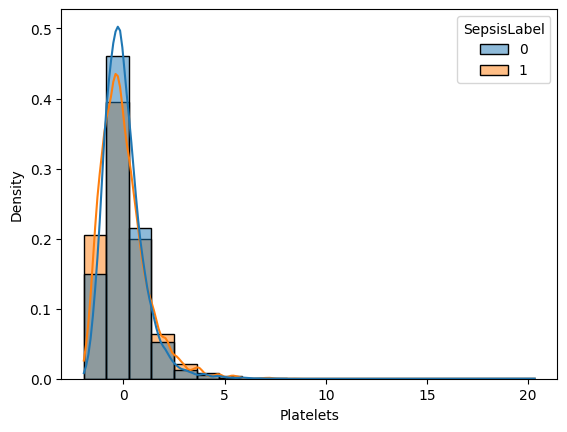

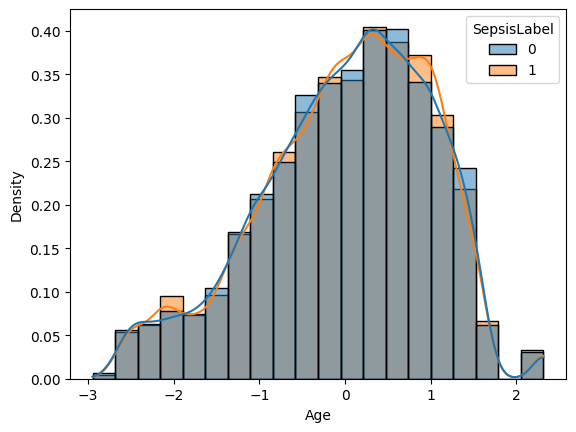

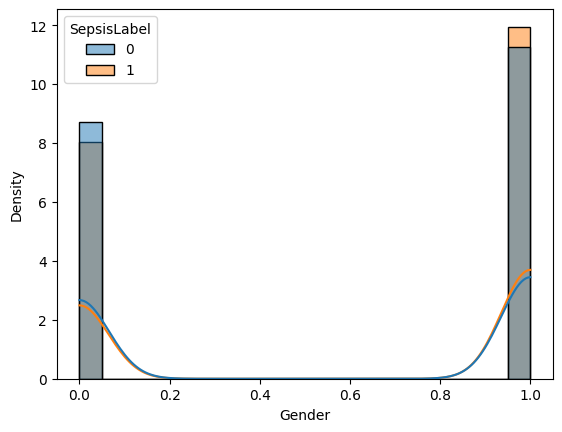

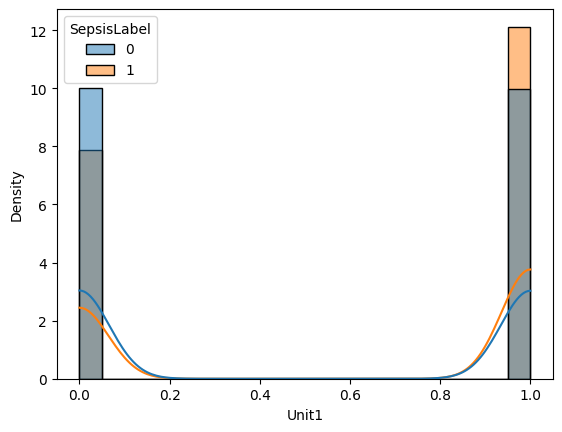

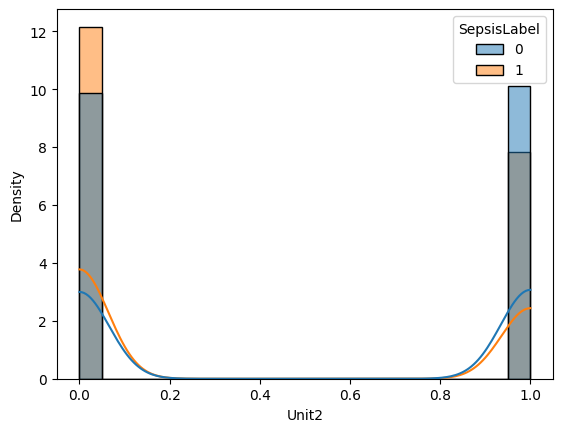

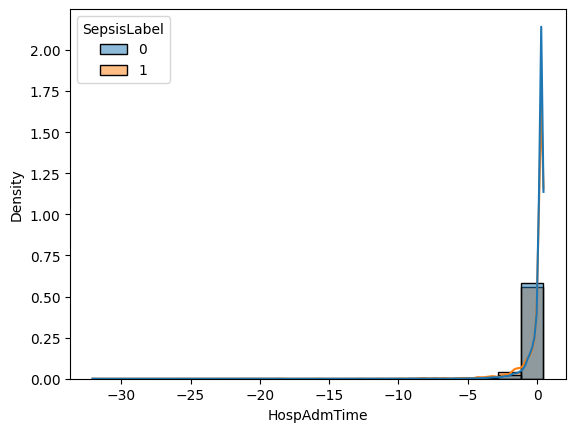

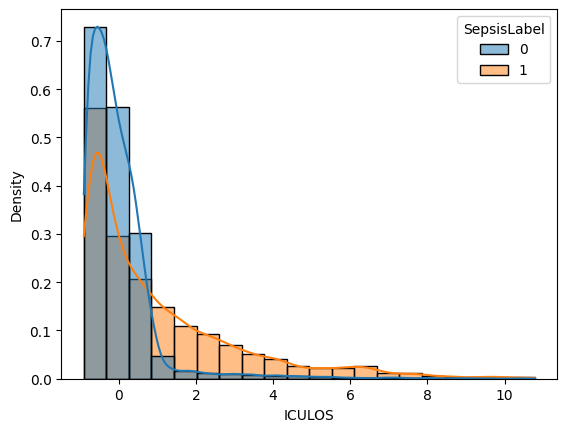

In [21]:
for col in cols:
  ax = sns.histplot(data=df_bal, x=col,hue="SepsisLabel", kde=True,bins=20, stat='density',common_norm=False)
  plt.show()

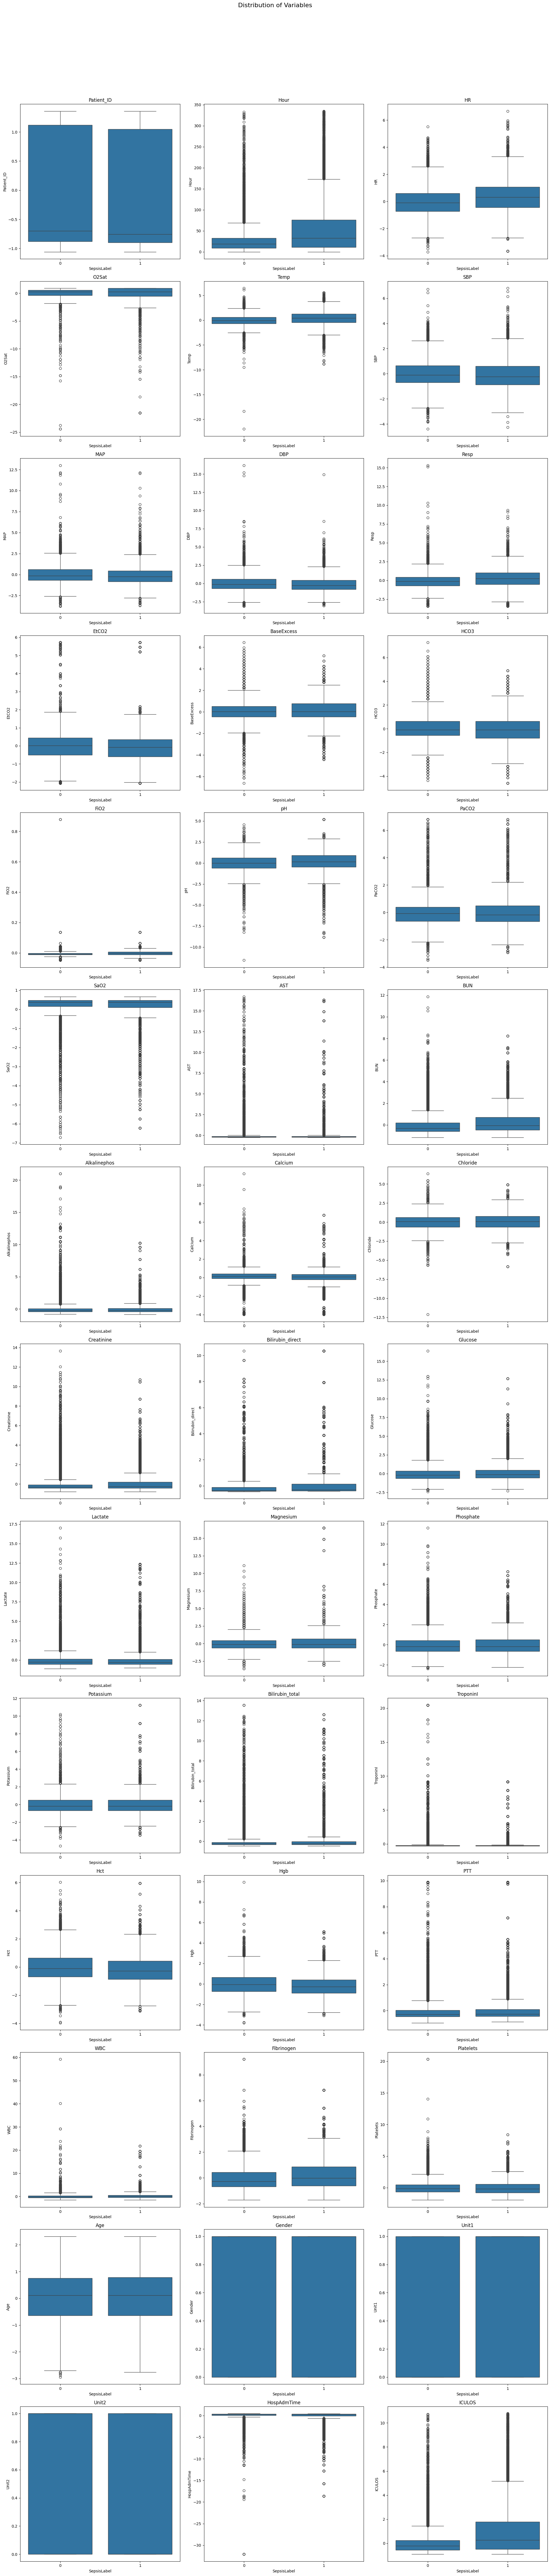

In [22]:
n_vars = len(cols)
n_rows = (n_vars + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(20, n_rows * 7))
fig.suptitle('Distribution of Variables', fontsize=16)

axes = axes.flatten()

for i, var in enumerate(cols):
    sns.boxplot(data=df_bal, x='SepsisLabel', y=var, ax=axes[i])
    axes[i].set_title(var)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<Axes: >

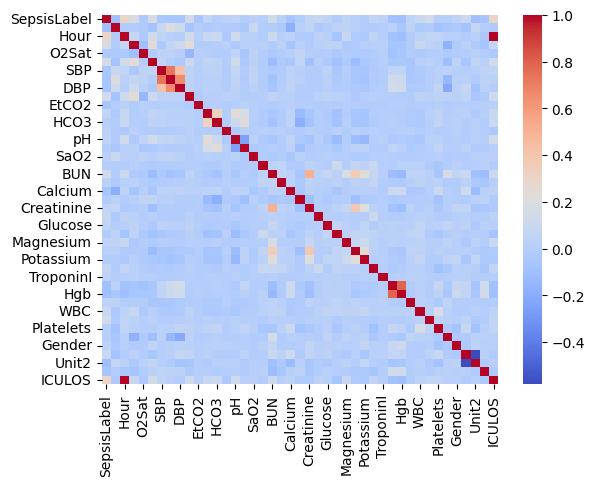

In [ ]:
sns.heatmap(df_bal.corr(), cmap='coolwarm')

Based on these graphs, we observe that some variables show interesting differences and variation between the septic and non-septic patients, suggesting that these variables could have a predicting effect. These variables are: Resp (Respiratory rate), SBP (Systollic Blood Pressure), BUN (Blood Urea Nitrogen), Lactate, WBC (White Blood Cell count), Creatinine, Platelets, HR (Heart Rate), OSat (Oxygen Saturation), Temp (temperature).

These visulisations not only help us narrows down to these variables of interest, but also helps confirm the relevant [theory](https://www.ncbi.nlm.nih.gov/books/NBK594258/) about indicators of Sepsis.

Now let's do more exploration with only just these specific variables.

In [ ]:
important_vars = ['Resp', 'SBP', 'BUN', 'Lactate', 'WBC', 'Creatinine', 'Platelets', 'HR', 'O2Sat', 'Temp']

summary_stats = df_bal.groupby('SepsisLabel')[important_vars].describe().transpose()

summary_stats = summary_stats.rename_axis(['Variable', 'Statistic']).reset_index()

display(summary_stats)

SepsisLabel,Variable,Statistic,0,1
0,Resp,count,27916.000000,27916.000000
1,Resp,mean,-0.007354,0.307848
2,Resp,std,1.006366,1.227549
3,Resp,min,-3.442437,-3.442437
4,Resp,25%,-0.619187,-0.521834
...,...,...,...,...
75,Temp,min,-7.727640,-8.838059
76,Temp,25%,-0.648721,-0.509919
77,Temp,50%,-0.093512,0.336775
78,Temp,75%,0.600500,1.294512


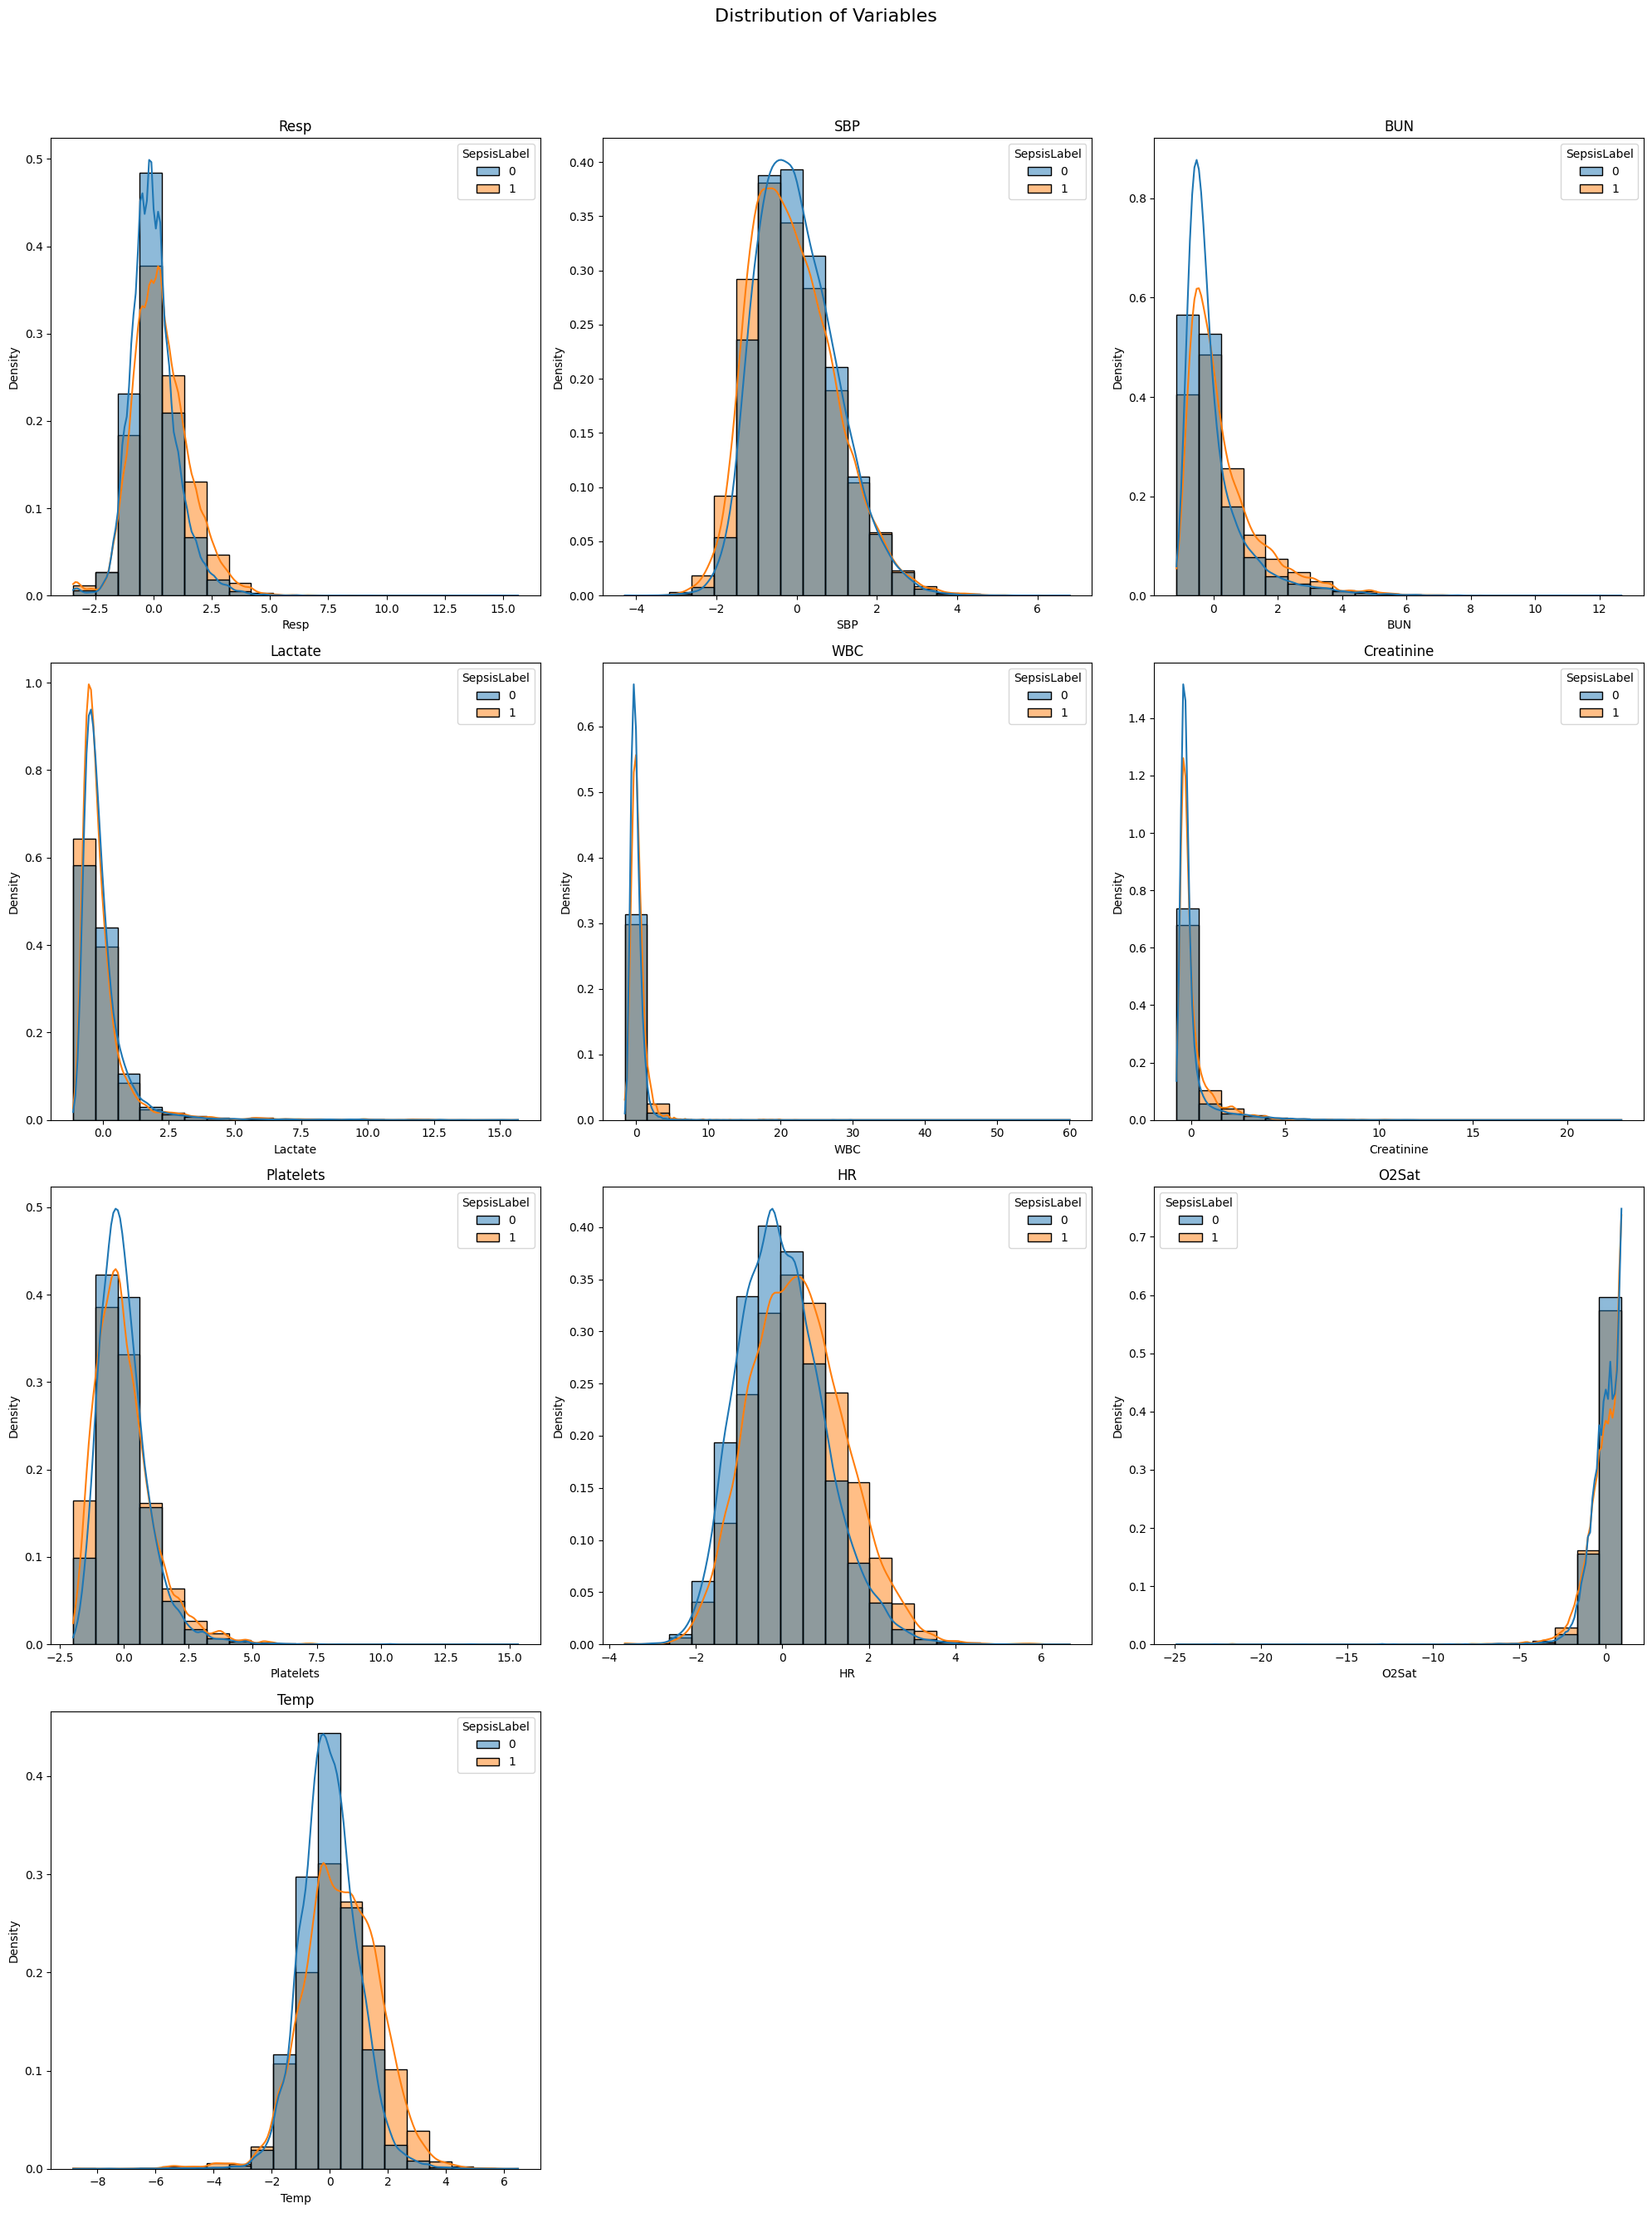

In [ ]:
n_vars = len(important_vars)
n_rows = (n_vars + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(20, n_rows * 7))
fig.suptitle('Distribution of Variables', fontsize=16)

axes = axes.flatten()

for i, var in enumerate(important_vars):
    sns.histplot(data=df_bal, x=var,hue="SepsisLabel", kde=True,bins=20, stat='density',common_norm=False, ax=axes[i])
    # sns.boxplot(data=df_bal, x='SepsisLabel', y=var, ax=axes[i])
    axes[i].set_title(var)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

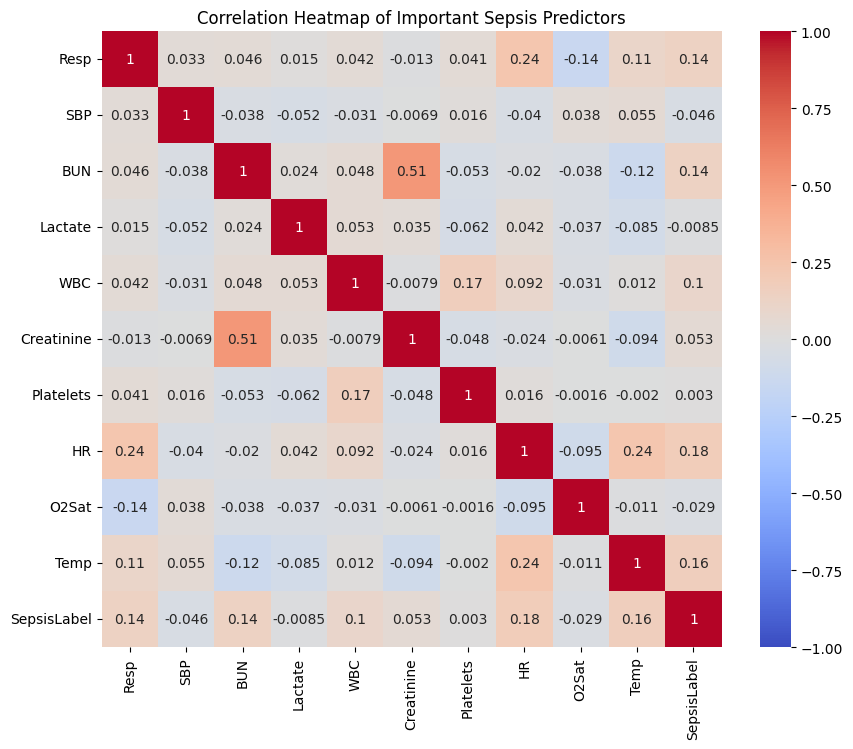

In [ ]:
#PLOT4: heatmap of important predictors and sepsis
important_vars.append("SepsisLabel")
correlation_matrix = df_bal[important_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Important Sepsis Predictors')
plt.show()
while 'SepsisLabel' in important_vars:
  important_vars.remove("SepsisLabel")

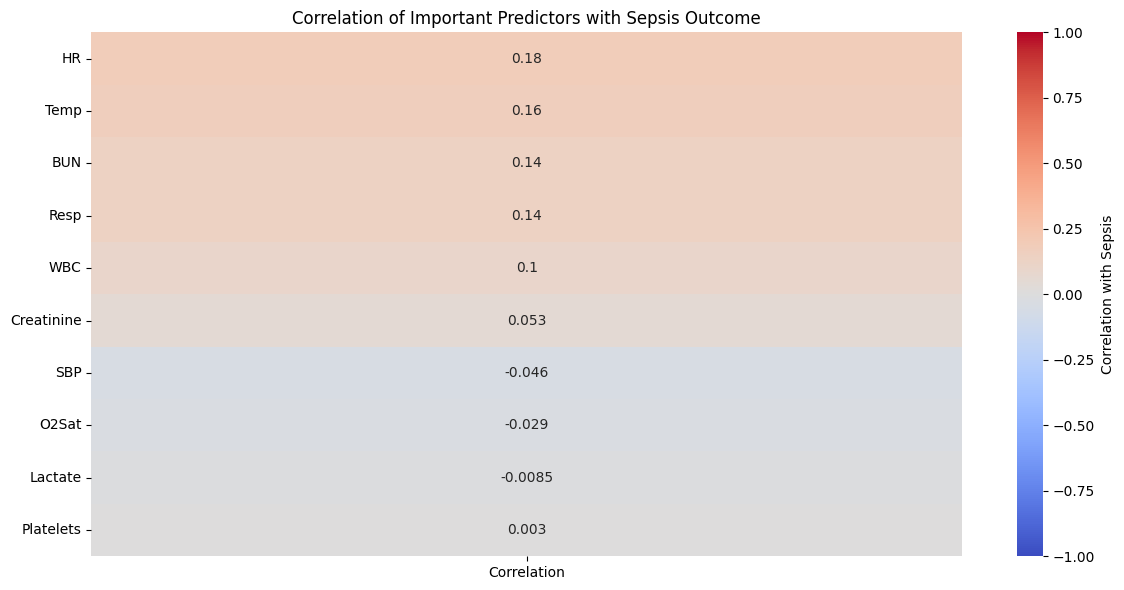

In [ ]:
from scipy.stats import pointbiserialr

correlations = []
for var in important_vars:
    corr, _ = pointbiserialr(df_bal['SepsisLabel'], df_bal[var])
    correlations.append(corr)

# Create a DataFrame for the correlations
corr_df = pd.DataFrame({'Variable': important_vars, 'Correlation': correlations})
corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_df.set_index('Variable'), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation with Sepsis'})
plt.title('Correlation of Important Predictors with Sepsis Outcome')
plt.ylabel('')
plt.tight_layout()
plt.show()